In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import PIL
import pickle
from PIL import *
import cv2
import tensorflow as tf
import keras
from keras.applications import DenseNet121 # 2017 architecture
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from keras import *
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, optimizers
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.regularizers import l2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
facialexpression_df = pd.read_csv('/content/drive/MyDrive/DL Facial Recognition/icml_face_data.csv')
facialexpression_df = facialexpression_df.drop(columns=" Usage")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def conv_block(X, f, filters, stage, block, strides=(2, 2), weight_decay=1e-3):
    F1, F2, F3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Save the input value for shortcut
    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides=strides, padding='valid', name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(weight_decay))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component
    X = Conv2D(F2, (f, f), padding='same', name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(weight_decay))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component
    X = Conv2D(F3, (1, 1), padding='valid', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(weight_decay))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=strides, padding='valid', name=conv_name_base + '1',
                        kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(weight_decay))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def identity_block(X, f, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut."""
    F1, F2, F3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component
    X = Conv2D(F2, (f, f), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component
    X = Conv2D(F3, (1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Add shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def apply_blocks(X, filter_triplets, first_strides, num_identity_blocks, stage):
    """Apply a convolutional block followed by multiple identity blocks."""
    # Apply the first convolutional block with stride changes
    X = conv_block(X, 3, filter_triplets, stage, 'a', strides=first_strides)
    # Apply subsequent identity blocks
    for i in range(num_identity_blocks):
        X = identity_block(X, 3, filter_triplets, stage, chr(98 + i))  # 'b', 'c', etc.
    return X


In [ ]:

# Define function to convert string to array
def string2array(x):
    return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')
# Define function to resize images
def resize(x):
    img = x.reshape(48, 48)
    return cv2.resize(img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)


In [ ]:

# Apply preprocessing to pixels column
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))
facialexpression_df[' pixels'] =  facialexpression_df[' pixels'].apply(lambda x : resize(x))
# Define emotions of interest
emotions = [1]  # Example: you want to work with emotion label 1
label_to_text = {0: 'anger', 1 : 'disgust', 2 : 'fear', 3 : 'happiness', 4: 'sad', 5: 'surprise', 6: 'neutral'}

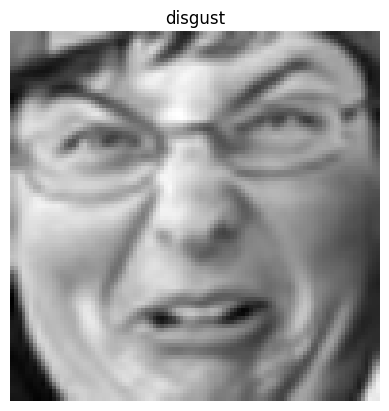

In [ ]:
# Plot sample images
for i in emotions:
    data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
    img = data[' pixels'].item()
    img = img.reshape(96, 96)

    plt.figure()
    plt.title(label_to_text[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')

In [ ]:
from keras.utils import to_categorical

# Prepare input and target data
X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])

X = np.stack(X, axis = 0)
X = X.reshape(35887,96,96,1)

from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

X_train = X_train/255
X_val   = X_val /255
X_test  = X_test/255

# Data Augmentation
train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest")


In [ ]:
# Define the input tensor shape
input_shape = (96, 96, 1)
X_input = Input(input_shape)

# Initial convolution and max pooling
X = ZeroPadding2D((3, 3))(X_input)
X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Dropout(0.5)(X)  # Add dropout
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(X)

# Helper function to apply a convolutional block and multiple identity blocks
def apply_blocks(X, filter_triplets, first_strides, num_identity_blocks, stage):
    # Apply convolutional block
    X = conv_block(X, 3, filter_triplets, stage, 'a', strides=first_strides)
    # Apply identity blocks
    for i in range(num_identity_blocks):
        X = identity_block(X, 3, filter_triplets, stage, chr(98 + i))  # 'b', 'c', ..., for identity blocks
    return X

# Stage 2
X = apply_blocks(X, [64, 64, 256], (1, 1), 2, 2)

# Stage 3
X = apply_blocks(X, [128, 128, 512], (2, 2), 3, 3)

# Stage 4
X = apply_blocks(X, [256, 256, 1024], (2, 2), 5, 4)

# Stage 5
X = apply_blocks(X, [512, 512, 2048], (2, 2), 2, 5)

# Global Average Pooling and final dense layer
X = GlobalAveragePooling2D()(X)
X = Dense(7, activation='softmax', name='final_output')(X)

# Create the model
model = Model(inputs=X_input, outputs=X, name='CustomResNet50')
# Show the model summary
model.summary()

Model: "CustomResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 102, 102, 1)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 48, 48, 64)           3200      ['zero_padding2d_4[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1[0][0]']  

In [ ]:
# Define the total number of epochs and the number of warmup epochs
# Define the total number of epochs, the number of warmup epochs, and the batch size
total_epochs = 100
warmup_epochs = 5
batch_size = 64

# Define the initial learning rate and minimum learning rate
initial_learning_rate = 1e-3
min_learning_rate = 1e-6

# Calculate the total number of steps and warmup steps
total_steps = total_epochs * (len(X_train) // batch_size)
warmup_steps = warmup_epochs * (len(X_train) // batch_size)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-6)

# Define the learning rate scheduler with warmup
# Create the learning rate scheduler with warmup
# def lr_schedule(epoch, lr):
#     if epoch < warmup_epochs:
#         # Linear warmup
#         return initial_learning_rate * (epoch + 1) / warmup_epochs
#     else:
#         # Cosine annealing with restarts
#         cosine_decay = 0.5 * (1 + tf.cos(tf.constant(np.pi) * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
#         decayed = (initial_learning_rate - min_learning_rate) * cosine_decay + min_learning_rate
#         return decayed
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "/content/drive/MyDrive/DL Facial Recognition /FacialExpression_weights_resnet.hdf5", verbose = 1, save_best_only=True)
# Compile the model
model.compile(keras.optimizers.Adam(lr = 1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)



Model: "CustomResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 102, 102, 1)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 48, 48, 64)           3200      ['zero_padding2d_4[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1[0][0]']  

In [ ]:
history = model.fit(train_generator, steps_per_epoch=len(X_train)//batch_size, epochs=total_epochs, validation_data=(X_val, y_val), validation_steps=len(X_val)//batch_size, callbacks=[checkpointer, earlystopping, reduce_lr])


Epoch 1/100
504/504 [==============================] - ETA: 0s - loss: 0.9022 - accuracy: 0.6823
Epoch 1: val_loss improved from inf to 1.24784, saving model to /content/drive/MyDrive/DL Facial Recognition /FacialExpression_weights_resnet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


504/504 [==============================] - 70s 86ms/step - loss: 0.9022 - accuracy: 0.6823 - val_loss: 1.2478 - val_accuracy: 0.5530 - lr: 0.0010
Epoch 2/100
504/504 [==============================] - ETA: 0s - loss: 0.8990 - accuracy: 0.6810
Epoch 2: val_loss improved from 1.24784 to 1.19534, saving model to /content/drive/MyDrive/DL Facial Recognition /FacialExpression_weights_resnet.hdf5
504/504 [==============================] - 49s 97ms/step - loss: 0.8990 - accuracy: 0.6810 - val_loss: 1.1953 - val_accuracy: 0.5686 - lr: 0.0010
Epoch 3/100
504/504 [==============================] - ETA: 0s - loss: 0.8911 - accuracy: 0.6845
Epoch 3: val_loss improved from 1.19534 to 1.12435, saving model to /content/drive/MyDrive/DL Facial Recognition /FacialExpression_weights_resnet.hdf5
504/504 [==============================] - 43s 84ms/step - loss: 0.8911 - accuracy: 0.6845 - val_loss: 1.1244 - val_accuracy: 0.5959 - lr: 0.0010
Epoch 4/100
504/504 [==============================] - ETA: 0s - l

In [62]:
score = model.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(score[1]))

57/57 [==============================] - 1s 11ms/step - loss: 1.0631 - accuracy: 0.6485
Test Accuracy: 0.6484679579734802


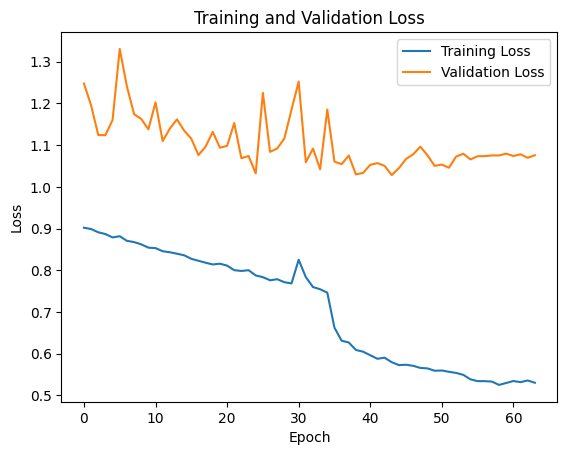

In [64]:
# Plotting loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()